In [1]:
import joblib

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [10]:
import pandas as pd

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
tests = pd.read_csv("tests.csv",delimiter=";")

In [12]:
tests.head()

,Product Code,The Measured Energy Ventilated Consumption,Declerated EEI,Measured Volume,Test Function,For 230V Total Working Cycle Power,Pulsation,Function Type,Buffle,Insulation Desc. Kg/m^3,Thermal Conductivity (W/mK),Cooling Fan Poer,Cooling fan Type ( T=tangetial fan)/R=radial fan),Cooling Fan RPM,Cavity Fan RPM,Number of glass,Cavity Type (F=Flat/E= Embossed),Ventilation Channel,Chimney (0: No/1:Yes)
0,33703472,0.68,A+,69.4,Cooklight,2410,Pulsation,Multifunction,New ECO,33,0.064,12.0,R,1100.0,1800,2,F,Ventilation Channel,1
1,33703472,0.68,A+,69.4,Cooklight,2410,Pulsation,Multifunction,New ECO,33,0.064,12.0,R,1100.0,1800,2,F,Ventilation Channel,1
2,33703472,0.68,A+,69.4,Cooklight,2410,Pulsation,Multifunction,New ECO,33,0.064,12.0,R,1100.0,1800,2,F,Ventilation Channel,1
3,33703472,0.72,A+,69.4,Cooklight,2410,Pulsation,Multifunction,New ECO,33,0.064,12.0,R,1100.0,1800,2,F,Ventilation Channel,1
4,33703472,0.72,A+,69.4,Cooklight,2410,Pulsation,Multifunction,New ECO,33,0.064,12.0,R,1100.0,1800,2,F,Ventilation Channel,1


## Importing the Preprocessor

In [6]:
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.columns)


In [7]:
preprocessor = joblib.load("preprocessor.joblib")

In [8]:
preprocessor

ColumnTransformer(transformers=[('Drop Product Code',
                                 DropColumns(columns=['Product Code ']),
                                 ['Product Code ']),
                                ('Ventilation Channel',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='No '
                                                                           'Ventilation '
                                                                           'Channel',
                                                                strategy='constant')),
                                                 ('One hot encode',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Ventilation Channel ']),
                                ('Cooling Fan Type',
                                 Pipeline(steps=[('impu...
                                 ['Cooling fan Type ( T=tangetial '
                                  'fan)/R=radial fan)']),
                                ('Cooling Fan Power and Cooling Fan RPM',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'))]),
                                 ['Cooling Fan Poer ', 'Cooling Fan RPM']),
                                ('Other Categorical Columns To Be Encoded',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Test Function ', 'Pulsation ', 'Buffle ',
                                  'Cavity Type  (F=Flat/E= Embossed)'])])

# Data Split

We Split the data into train,test and validation sets, <br>
Train sets will be used to train the model,<br>
Validation sets will be used to tune the hyperparameters of the model, using grid search Cross Validation<br>
And The Test sets will be used to evaluate the final performance of the model.

In [14]:
X = tests.drop(['The Measured Energy Ventilated Consumption',
       'Declerated EEI'],axis=1)

In [15]:
y = tests['The Measured Energy Ventilated Consumption']

In [19]:
X = preprocessor.fit_transform(X)

In [20]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Random Forest Regressor

In [13]:
from sklearn.ensemble import RandomForestRegressor

In [45]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [47]:
import numpy as np

### Tuning The Hyperparameters 

In [37]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['log2', 'sqrt']
}

In [38]:
rf_regressor = RandomForestRegressor()

In [39]:
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5,verbose=1,error_score="raise")

In [40]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(cv=5, error_score='raise', estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=1)

In [41]:
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}


In [81]:
best_rf_regressor = RandomForestRegressor(**best_params)

In [82]:
best_rf_regressor.fit(X_train,y_train)

RandomForestRegressor(max_features='sqrt', min_samples_split=10,
                      n_estimators=300)

In [83]:
y_train_pred = best_rf_regressor.predict(X_train)
validation_score = mean_squared_error(y_train, y_train_pred)
print("Training set Mean Squared Error: " + str(validation_score))
print("Training set Root Mean Squared Error: " + str(np.sqrt(validation_score)))
y_val_pred = best_rf_regressor.predict(X_val)
validation_score = mean_squared_error(y_val, y_val_pred)
print("Validation set Mean Squared Error: " + str(validation_score))
print("Validation set Root Mean Squared Error: " + str(np.sqrt(validation_score)))
y_test_pred = best_rf_regressor.predict(X_test)
validation_score = mean_squared_error(y_test, y_test_pred)
print("Test set Mean Squared Error: " + str(validation_score))
print("Test set Root Mean Squared Error: " + str(np.sqrt(validation_score)))

Training set Mean Squared Error: 0.0016117634475742446
Training set Root Mean Squared Error: 0.04014677381277659
Validation set Mean Squared Error: 0.0021005558008446424
Validation set Root Mean Squared Error: 0.045831820832742856
Test set Mean Squared Error: 0.0017590451894805058
Test set Root Mean Squared Error: 0.04194097268162132


Since Training, Validation and Test errors are similar, it can be said that there is no overfitting. 

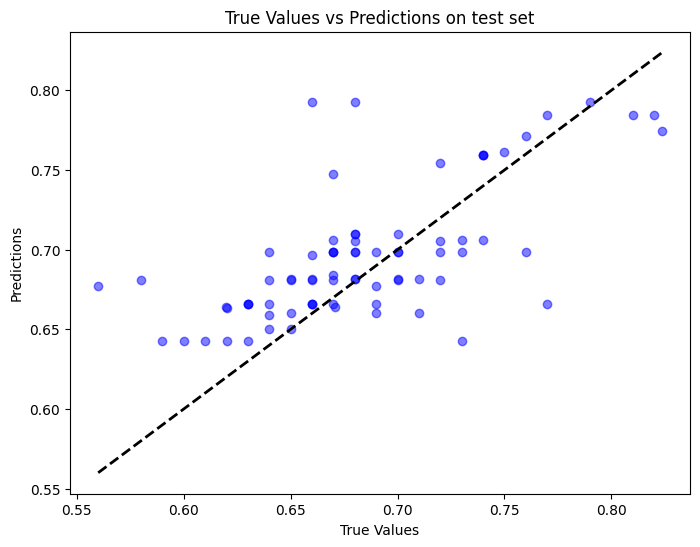

In [60]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', alpha=0.5)  # Scatter plot of real vs predicted values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions on test set')
plt.show()

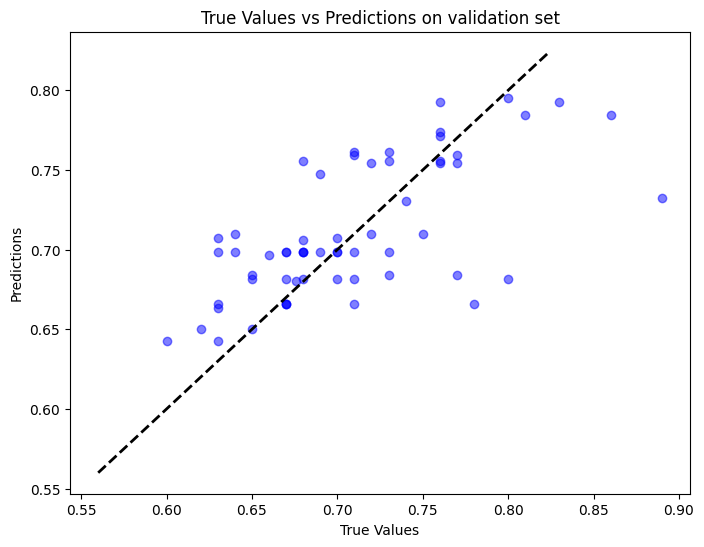

In [61]:
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_val_pred, color='blue', alpha=0.5)  # Scatter plot of real vs predicted values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions on validation set')
plt.show()

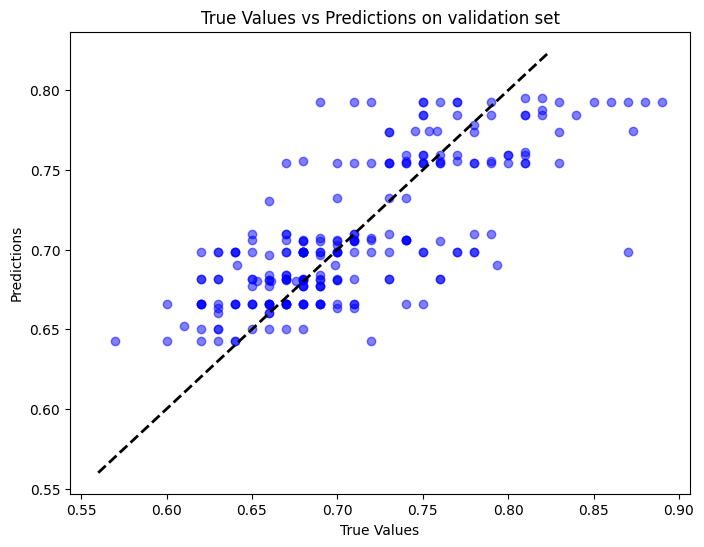

In [62]:
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.5)  # Scatter plot of real vs predicted values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions on validation set')
plt.show()

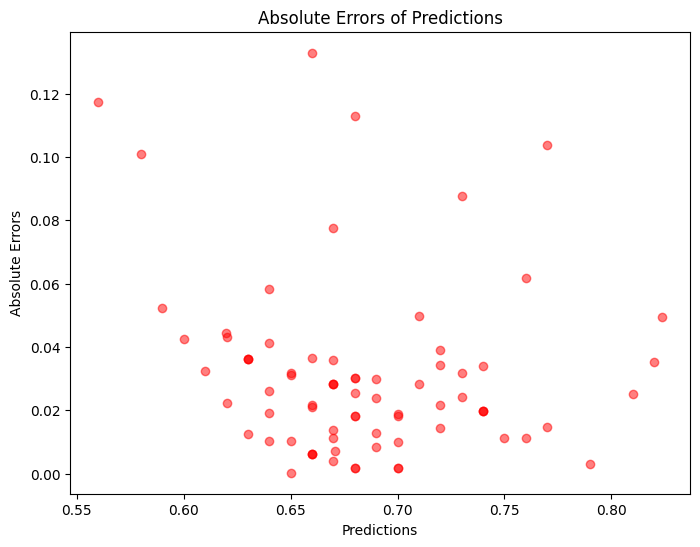

In [79]:
# Plot the errors
errors = np.abs(y_test - y_test_pred)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, errors, color='red', alpha=0.5)  # Scatter plot of predicted values vs errors
plt.xlabel('Predictions')
plt.ylabel('Absolute Errors')
plt.title('Absolute Errors of Predictions')
plt.show()

# Saving The Model

In [ ]:
joblib.dump(best_r)